# Isomap Embedding: S-curve and Swiss Roll Data Sets

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import manifold, datasets

np.set_printoptions(suppress=True)

## Generate S-curve Data set 

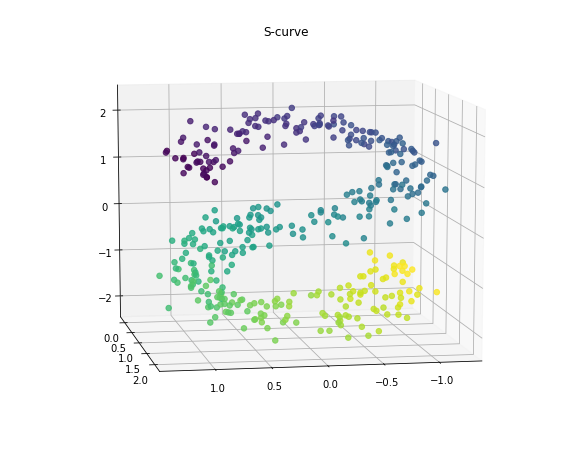

In [2]:
X, col = datasets.make_s_curve(400, noise=0.1, random_state=1)

x, y, z = X.T
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=col, s=30, alpha=0.8)
ax.view_init(azim=80, elev=10)
ax.set_title('S-curve')
plt.show()

## Create kNN Graph class

In [3]:
class knnGraph:
    def __init__(self, X, metric='euclidean', k=5):
        self.X = X
        self.k = k
        self.metric = metric
        
        # Get the pairwise distances
        D = pairwise_distances(self.X, self.X, 
                               metric=metric)
        
        # Set the distance of non-adjacent pts to Inf
        for i in range(len(X)):
            D[i, D[i,:] > D[i,np.argsort(D[i,:])[k]]] = np.Inf
        
        # Ensure that D is symmetric (knn graph is undirected)
        D = np.minimum(D, D.T)
        
        self.D = D
        self.draw_graph()
        
    def draw_graph(self):
        x, y, z = self.X.T
        fig = plt.figure(figsize=(10,8))
        ax = plt.axes(projection='3d')
        ax.scatter(x, y, z, c=col, s=30, alpha=0.8)
        ax.view_init(azim=80, elev=10)
        ax.set_title('K-neighbors Graph')
        
        for i in range(len(self.X)):
            # ax.text(self.X[i,0], self.X[i,1], self.X[i,2], str(i))
            for j in range(len(self.X)):
                if self.D[i,j] > 0 and self.D[i,j] < np.Inf:
                    plt.plot(np.array([self.X[i,0], self.X[j,0]]),
                             np.array([self.X[i,1], self.X[j,1]]),
                             np.array([self.X[i,2], self.X[j,2]]),
                             color='k', alpha=0.2)
        plt.show()

## Create myIsomap class

In [4]:
class myIsomap:
    def __init__(self, metric='euclidean', k=5):
        self.metric = metric
        self.k = k
        
    def fit_transform(self, X):
        
        # Create an instance of kNN graph
        kNNG = knnGraph(X, metric=self.metric, k=self.k)
        
        self.kNNG = kNNG
        self.X = X
        
        # Initialize D with the contents of kNNG.D
        D = np.zeros(kNNG.D.shape)
        for i in range(len(X)):
            for j in range(len(X)):
                D[i,j] = kNNG.D[i,j]
        
        # Use Floyd-Warshall algorithm to find the
        # all-pairs shortest path distance
        for k in range(len(X)):
            for i in range(len(X)):
                for j in range(i+1, len(X)):
                    D[i,j] = min(D[i,j], D[i,k] + D[k,j])
                    D[j,i] = D[i,j]
        
        self.D = D
        
        # Visualize the distance matrix
        #plt.figure(figsize=(8,8))
        #plt.imshow(self.D)
        #plt.title('Shortest Path Distance Matrix (from scratch)')
        #plt.colorbar(shrink=0.8)
        #plt.show()
        
        # Following Tenenbaum et al. (2000), we solve an eig problem
        self.D[self.D == np.inf] = 0
        n = len(self.X)
        H = np.eye(n) - np.ones((n, n))/n
        tau = -0.5 * H @ (self.D ** 2) @ H
        
        # Ensure symmetry by averaging out small errors
        tau = (tau + tau.T)/2
        
        # Eigenvalue decomposition with sorted eigs ascending (eigh)
        eigvals, eigvecs = np.linalg.eigh(tau)
                
        # Compute the embeddings and scores
        self.embedding = eigvecs[:,-2:] @ np.diag(1/np.sqrt(eigvals[-2:]))
        scores = tau.dot(self.embedding)
        return scores

## Apply Isomap on the S-curve Data Set

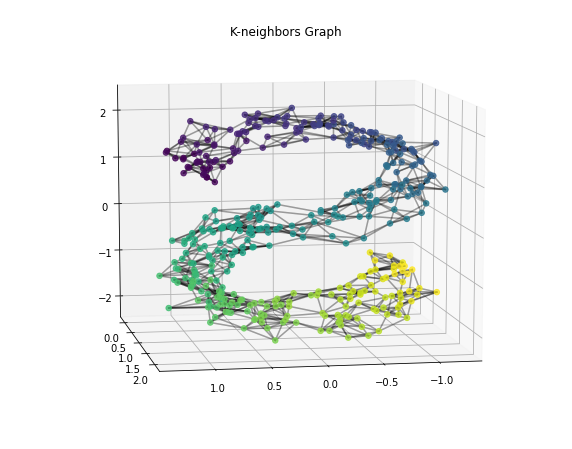

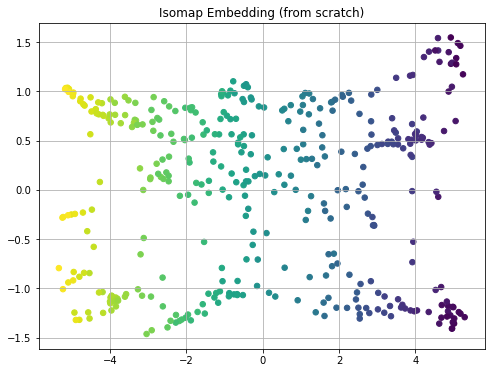

In [5]:
iso = myIsomap(metric='euclidean', k=5)
scores = iso.fit_transform(X)

plt.figure(figsize=(8,6))
plt.scatter(scores[:,1], scores[:,0], c=col, s=30)
plt.title('Isomap Embedding (from scratch)')
plt.grid()
plt.show()

## Compare with sklearn Isomap and sklearn kneighbors_graph

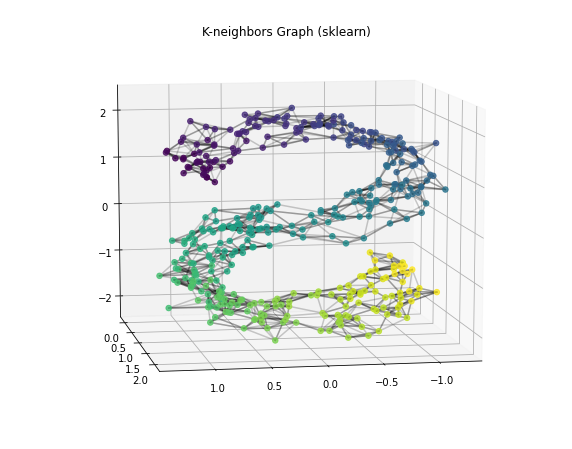

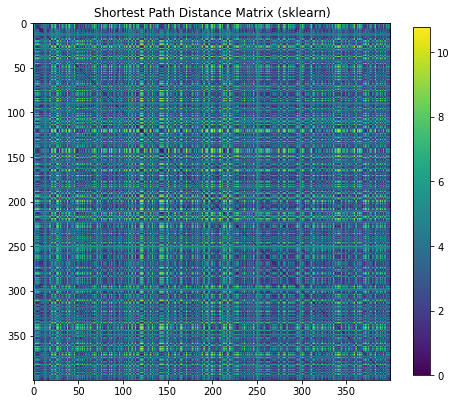

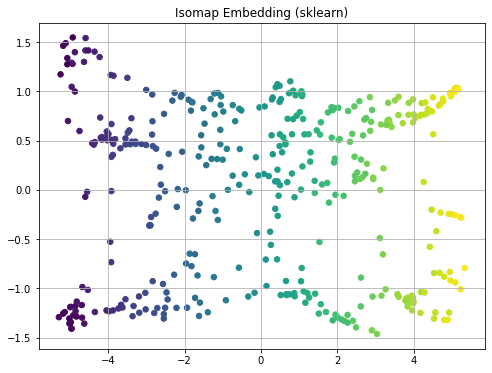

In [6]:
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import Isomap

A = kneighbors_graph(X, n_neighbors=5, mode='distance')
#print(np.around(A.toarray(),3))

# Visualize the kneighbors_graph
x, y, z = X.T
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=col, s=30, alpha=0.8)
ax.view_init(azim=80, elev=10)
ax.set_title('K-neighbors Graph (sklearn)')

for i in range(len(X)):
    for j in range(len(X)):
        if A[i,j] > 0 and A[i,j] < np.Inf:
            plt.plot(np.array([X[i,0], X[j,0]]),
                     np.array([X[i,1], X[j,1]]),
                     np.array([X[i,2], X[j,2]]),
                     color='k', alpha=0.2)
plt.show()

# Perform isomap embedding in 2D
iso2 = Isomap(n_components=2, n_neighbors=5)
scores = iso2.fit_transform(X)

# Visualize the distance matrix
plt.figure(figsize=(8,8))
plt.imshow(iso2.dist_matrix_)
plt.title('Shortest Path Distance Matrix (sklearn)')
plt.colorbar(shrink=0.8)
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(scores[:,0], scores[:,1], c=col, s=30)
plt.title('Isomap Embedding (sklearn)')
plt.grid()
plt.show()

## Do the same for the Swiss Roll Data Set

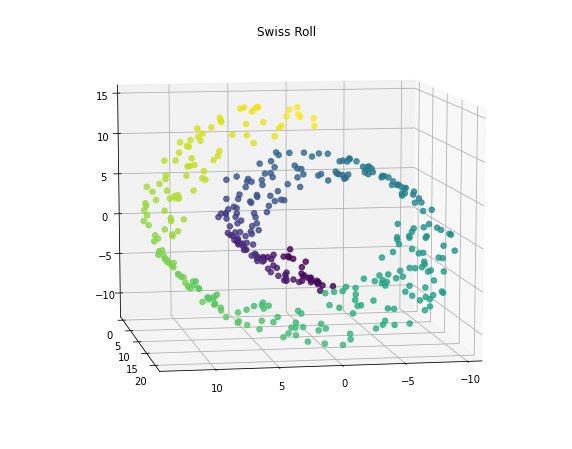

In [7]:
X, col = datasets.make_swiss_roll(400, noise=0.1, random_state=1)

x, y, z = X.T
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
ax.scatter(x, y, z, c=col, s=30, alpha=0.8)
ax.view_init(azim=80, elev=10)
ax.set_title('Swiss Roll')
plt.show()

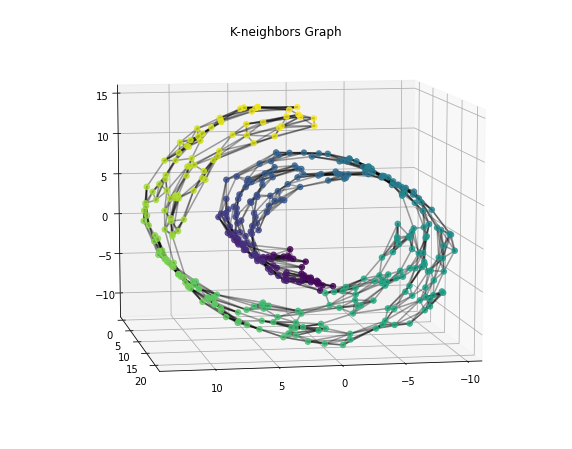

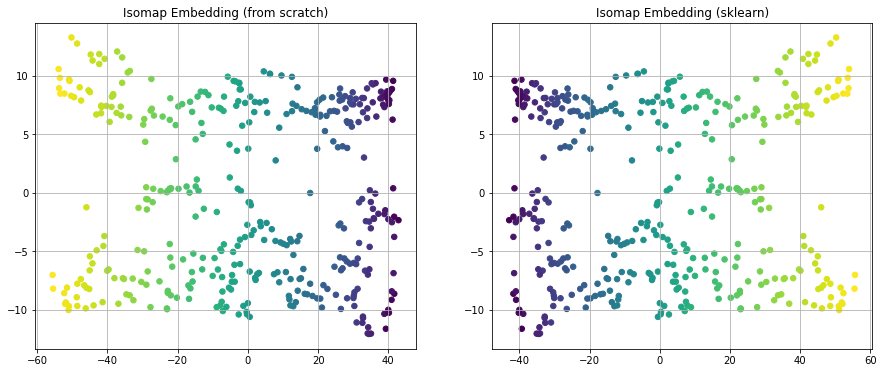

In [8]:
iso = myIsomap(metric='euclidean', k=6)
scores = iso.fit_transform(X)

iso2 = Isomap(n_components=2, n_neighbors=6)
scores2 = iso2.fit_transform(X)

# Visualize the 2D embedding
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.scatter(scores[:,1], scores[:,0], c=col, s=30)
plt.title('Isomap Embedding (from scratch)')
plt.grid()
plt.subplot(122)
plt.scatter(scores2[:,0], scores2[:,1], c=col, s=30)
plt.title('Isomap Embedding (sklearn)')
plt.grid()

plt.show()

## View the kNN graph in lower dimensional space 

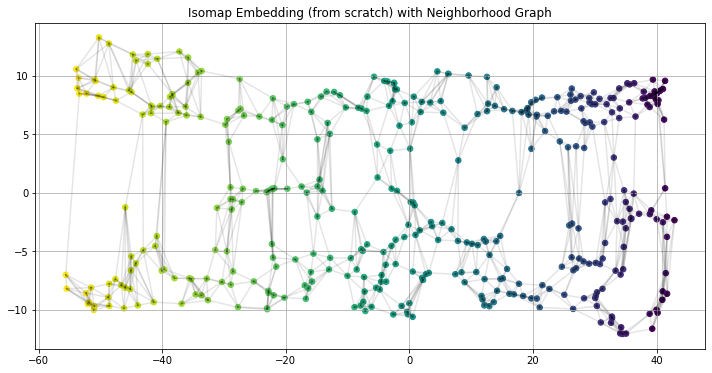

In [9]:
plt.figure(figsize=(12,6))
plt.scatter(scores[:,1], scores[:,0], c=col, s=30)
plt.title('Isomap Embedding (from scratch) with Neighborhood Graph')
plt.grid()

for i in range(len(scores)):
    for j in range(len(scores)):
        if iso.kNNG.D[i,j] > 0 and iso.kNNG.D[i,j] < np.Inf:
            plt.plot(np.array([scores[i,1], scores[j,1]]),
                     np.array([scores[i,0], scores[j,0]]),
                     color='k', alpha=0.05)

plt.show()

This result shows that our Isomap successfully unfolded the underlying manifold of data that lived in high dimensions.